In [6]:
# This code is provided for Deep Learning (CS 482/682) Homework 6 practice.
# The network structure is a simplified U-net. You need to finish the last layers
# @Copyright Cong Gao, the Johns Hopkins University, cgao11@jhu.edu
# Modified by Hongtao Wu on Oct 11, 2019 for Fall 2019 Machine Learning: Deep Learning HW6

#Jason Zhang Jzhan127

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import autograd
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms 
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt

# Plot training loss, validation loss
def plot(training_loss, validation_loss):
    plt.figure(300)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')   
    plt.plot(training_loss, 'b', label='Training')
    plt.plot(validation_loss, 'r', label= 'Validation')
    plt.legend()


# 1 A

In [7]:
# Functions for adding the convolution layer
def add_conv_stage(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, useBN=False):
    if useBN:
        # Use batch normalization
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.BatchNorm2d(dim_out),
          nn.LeakyReLU(0.1)
        )
    else:
        # No batch normalization
        return nn.Sequential(
          nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU(),
          nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
          nn.ReLU()
        )


# Upsampling
def upsample(ch_coarse, ch_fine):
    return nn.Sequential(
        nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
        nn.ReLU()
        )


# U-Net
class unet(nn.Module):
    def __init__(self, useBN=False):
        super(unet, self).__init__()
        # Downgrade stages
        self.conv1 = add_conv_stage(3, 32, useBN=useBN)
        self.conv2 = add_conv_stage(32, 64, useBN=useBN)
        self.conv3 = add_conv_stage(64, 128, useBN=useBN)
        self.conv4 = add_conv_stage(128, 256, useBN=useBN)
        # Upgrade stages
        self.conv3m = add_conv_stage(256, 128, useBN=useBN)
        self.conv2m = add_conv_stage(128,  64, useBN=useBN)
        self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
        # Maxpool
        self.max_pool = nn.MaxPool2d(2)
        # Upsample layers
        self.upsample43 = upsample(256, 128)
        self.upsample32 = upsample(128,  64)
        self.upsample21 = upsample(64 ,  32)
        # weight initialization
        # You can have your own weight intialization. This is just an example.
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()

        #TODO: Design your last layer & activations
        self.convLast = nn.Conv2d(32, 8, kernel_size=1)

    def forward(self, x):
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(self.max_pool(conv1_out))
        conv3_out = self.conv3(self.max_pool(conv2_out))
        conv4_out = self.conv4(self.max_pool(conv3_out))

        conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
        conv3m_out  = self.conv3m(conv4m_out_)

        conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
        conv2m_out  = self.conv2m(conv3m_out_)

        conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
        conv1m_out  = self.conv1m(conv2m_out_)

        #TODO: Design your last layer & activations
        convfinal_out = self.convLast(conv1m_out)

        return torch.softmax(convfinal_out, dim=1)

In [3]:
######################## Hyperparameters #################################
# Batch size can be changed if it does not match your memory, please state your batch step_size
# in your report.
train_batch_size = 10
validation_batch_size=10
# Please use this learning rate for Prob1(a) and Prob1(b)
learning_rate = 0.001
# This num_epochs is designed for running to be long enough, you need to manually stop or design
# your early stopping method.
num_epochs = 10

# TODO: Design your own dataset
class ImageDataset(Dataset):
    def __init__(self, input_dir):
        datalist = []
        labellist = []
        onehotlabellist = []
        for folders in os.listdir(input_dir):
            new_dir = os.path.join(input_dir, folders)
            if os.path.isdir(new_dir):
                impath = new_dir+ '/'+folders+'_input.jpg'
                labelpath = new_dir+ '/'+folders+'_mask.png'
                im = Image.open(impath)
                imLab = Image.open(labelpath)
                datalist.append(np.array(im))
                labellist.append(np.array(imLab))
        test = np.transpose(np.array(datalist), (0, 3, 1, 2))
        self.data = torch.from_numpy(np.transpose(np.array(datalist), (0, 3, 1, 2))).type('torch.FloatTensor')
        npLabel = np.array(labellist)
        labels = [0, 32, 64, 96, 128, 160, 192, 224]
        
        #Create One Hot encoding
        for i in npLabel:
            imgs = []
            for j in labels:
                mask = self.mask(i, j)
                imgs.append(mask)
            onehotlabellist.append(np.array(imgs))
        self.label = torch.from_numpy(np.array(onehotlabellist)).type('torch.FloatTensor')
        
        
    def mask(self, label, val):
        return label == val
        
    def __len__ (self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.label[idx]

def dice_coeff(y_hat, y):
    eps = 1
    loss = 0
    classes = y_hat.shape[0]
    total = 0
    for i in range(classes):
        flatInp = y_hat[i].flatten()
        flatLabel = y[i].flatten()
        intersect = (flatInp * flatLabel).sum()
        total += ((2. * intersect + eps) /
                    (flatInp.sum() + flatLabel.sum() + eps))
    return total / classes
    
# TODO: Implement DICE loss
class DICELoss(nn.Module):
    def forward(self, y_hat, y):
        dice = dice_coeff(y_hat, y)
        return 1 - dice
 

# TODO: Use your designed dataset for dataloading
train_dataset=ImageDataset(input_dir = "./HW6_data/segmentation/train/")
validation_dataset=ImageDataset(input_dir =  "./HW6_data/segmentation/validation/")
model = unet(useBN = True)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                       batch_size=train_batch_size, 
                                       shuffle=True)
    
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                           batch_size=validation_batch_size, 
                                           shuffle=True)

training_loss = []
validation_loss = []
training_iter = iter(train_loader)
validation_iter = iter(validation_loader)
print("Start Training...")
for epoch in range(num_epochs):

    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    model.train()
    train_loss_tot = 0
    count = 0
    for ind, training_data in enumerate(train_loader):
        x = autograd.Variable(training_data[0]).cuda()
        y = autograd.Variable(training_data[1]).long().cuda()

        optimizer.zero_grad()
        y_hat = model(x)
        train_loss = DICELoss()(y_hat, y)
        train_loss.backward()
        optimizer.step()
        train_loss_tot += train_loss.data.item()
        count += 1
    training_loss.append(train_loss_tot / count)
    print("Training Loss: ", train_loss_tot / count)
    

    ########################### Validation #####################################
    # TODO: Design your own validation section
    print("\nStart Validation...")
    valid_loss_tot = 0
    count = 0
    model.eval()
    with torch.no_grad():
        for ind, valid_data in enumerate(validation_loader):
            x = autograd.Variable(valid_data[0]).cuda()
            y = autograd.Variable(valid_data[1]).long().cuda()
            y_hat = model(x)
            val_loss = DICELoss()(y_hat, y)
            valid_loss_tot += val_loss.data
            count += 1
        validation_loss.append(valid_loss_tot / count)
        print("Validation Loss: ", valid_loss_tot / count)
    

Start Training...

EPOCH 1 of 10

Training Loss:  0.6748512327671051

Start Validation...
Validation Loss:  tensor(0.6252, device='cuda:0')

EPOCH 2 of 10

Training Loss:  0.4966276486714681

Start Validation...
Validation Loss:  tensor(0.3827, device='cuda:0')

EPOCH 3 of 10

Training Loss:  0.36653361916542054

Start Validation...
Validation Loss:  tensor(0.2929, device='cuda:0')

EPOCH 4 of 10

Training Loss:  0.27095990975697837

Start Validation...
Validation Loss:  tensor(0.2669, device='cuda:0')

EPOCH 5 of 10

Training Loss:  0.20434389313062032

Start Validation...
Validation Loss:  tensor(0.1712, device='cuda:0')

EPOCH 6 of 10

Training Loss:  0.16439082821210224

Start Validation...
Validation Loss:  tensor(0.1725, device='cuda:0')

EPOCH 7 of 10

Training Loss:  0.14038116137186687

Start Validation...
Validation Loss:  tensor(0.1402, device='cuda:0')

EPOCH 8 of 10

Training Loss:  0.1260522464911143

Start Validation...
Validation Loss:  tensor(0.1271, device='cuda:0')



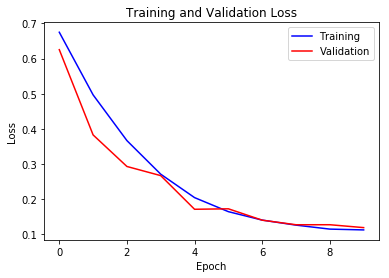

In [4]:
plot(training_loss, validation_loss)

Average Dice Score Accuracy:  0.8796414136886597


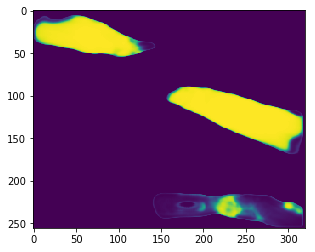

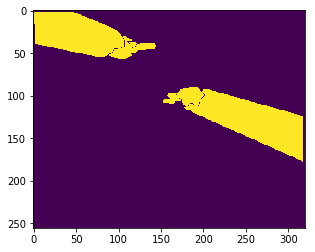

In [6]:
test_dataset=ImageDataset(input_dir = "./HW6_data/segmentation/test/")    
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                       batch_size=10)
def dice_coeff(y_hat, y):
    eps = 1
    loss = 0
    classes = y_hat.shape[0]
    total = 0
    for i in range(classes):
        flatInp = y_hat[i].flatten()
        flatLabel = y[i].flatten()
        intersect = (flatInp * flatLabel).sum()
        total += ((2. * intersect + eps) /
                    (flatInp.sum() + flatLabel.sum() + eps))
    return total / classes

score_tot = 0
count = 0
with torch.no_grad():
    for ind, data in enumerate(test_loader):
        model.eval()
        x = autograd.Variable(data[0]).cuda()
        y = autograd.Variable(data[1]).long().cuda()
        y_hat = model(x)

        # visualization of one of the mask and outputs
        # Output
        plt.figure(100)
        plt.imshow(y_hat[0][3].cpu().detach())
        # Mask
        plt.figure(200)
        plt.imshow(y[0][3].cpu().detach())
        acc = dice_coeff(y_hat, y)
        score_tot += acc.item()
        count += 1
    
    print("Average Dice Score Accuracy: ",score_tot/count)
    

# 1 B Data Augmentation

In [3]:
import random
######################## Hyperparameters #################################
# Batch size can be changed if it does not match your memory, please state your batch step_size
# in your report.
train_batch_size = 10
validation_batch_size=10
# Please use this learning rate for Prob1(a) and Prob1(b)
learning_rate = 0.001
# This num_epochs is designed for running to be long enough, you need to manually stop or design
# your early stopping method.
num_epochs = 10

# TODO: Design your own dataset
class ImageDatasetAugmentation(Dataset):
    def __init__(self, input_dir, transform=False):
        datalist = []
        labellist = []
        onehotlabellist = []
        for folders in os.listdir(input_dir):
            new_dir = os.path.join(input_dir, folders)
            if os.path.isdir(new_dir):
                impath = new_dir+ '/'+folders+'_input.jpg'
                labelpath = new_dir+ '/'+folders+'_mask.png'
                im = Image.open(impath)
                imLab = Image.open(labelpath)
                datalist.append(np.array(im))
                labellist.append(np.array(imLab))
        test = np.transpose(np.array(datalist), (0, 3, 1, 2))
        self.data = torch.from_numpy(np.transpose(np.array(datalist), (0, 3, 1, 2))).type('torch.FloatTensor')
        npLabel = np.array(labellist)
        labels = [0, 32, 64, 96, 128, 160, 192, 224]
        for i in npLabel:
            imgs = []
            for j in labels:
                mask = self.mask(i, j)
                imgs.append(mask)
            onehotlabellist.append(np.array(imgs))
        self.label = torch.from_numpy(np.array(onehotlabellist)).type('torch.FloatTensor')
        self.transform = transform
        
    def mask(self, label, val):
        return label == val
        
    def __len__ (self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.label[idx]
        # Vertical Flip
        if self.transform:
            if random.random() > 0.8:
                if random.random() > 0.7:
                    data = data.permute(1, 2, 0)
                    data = transforms.ToTensor()(TF.vflip(transforms.ToPILImage()(np.uint8(data))))
                    for i in range(label.shape[0]):
                        label[i] = transforms.ToTensor()(TF.vflip(transforms.ToPILImage()(np.uint8(label[i]))))
                # Horizontal Flip
                if random.random() > 0.7:
                    data = data.permute(1, 2, 0)
                    data = transforms.ToTensor()(TF.hflip(transforms.ToPILImage()(np.uint8(data))))
                    for i in range(label.shape[0]):
                        label[i] = transforms.ToTensor()(TF.hflip(transforms.ToPILImage()(np.uint8(label[i]))))

                # Change Brightness, Hue, Saturation
                if random.random() > 0.7:
                    data = data.permute(1, 2, 0)
                    data = transforms.ToTensor()(transforms.ColorJitter(brightness=random.uniform(0, 1), hue=random.uniform(0, 0.5), 
                                                                        saturation=random.uniform(0, 1))
                                                 (transforms.ToPILImage()(np.uint8(data))))  
        return data, label


def dice_coeff(y_hat, y):
    eps = 1
    loss = 0
    classes = y_hat.shape[0]
    total = 0
    for i in range(classes):
        flatInp = y_hat[i].flatten()
        flatLabel = y[i].flatten()
        intersect = (flatInp * flatLabel).sum()
        total += ((2. * intersect + eps) /
                    (flatInp.sum() + flatLabel.sum() + eps))
    return total / classes
    
# TODO: Implement DICE loss
class DICELoss(nn.Module):
    def forward(self, y_hat, y):
        dice = dice_coeff(y_hat, y)
        return 1 - dice
 
 

# TODO: Use your designed dataset for dataloading
train_dataset=ImageDatasetAugmentation(input_dir = "./HW6_data/segmentation/train/", transform=True)
validation_dataset=ImageDatasetAugmentation(input_dir =  "./HW6_data/segmentation/validation/")
model_aug = unet(useBN = True)
model_aug.cuda()
optimizer = torch.optim.Adam(model_aug.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                       batch_size=train_batch_size, 
                                       shuffle=True)
    
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                           batch_size=validation_batch_size, 
                                           shuffle=True)

training_loss = []
validation_loss = []
training_iter = iter(train_loader)
validation_iter = iter(validation_loader)
print("Start Training...")
for epoch in range(num_epochs):

    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    model_aug.train()
    train_tot = 0
    count = 0
    for ind, training_data in enumerate(train_loader):
        x = autograd.Variable(training_data[0]).cuda()
        y = autograd.Variable(training_data[1]).long().cuda()

        optimizer.zero_grad()
        y_hat = model_aug(x)
        train_loss = DICELoss()(y_hat, y)
        train_loss.backward()
        optimizer.step()
        count += 1
        train_tot += train_loss.data.item()
    print(train_tot / count)
    training_loss.append(train_tot / count)
    

    ########################### Validation #####################################
    # TODO: Design your own validation section
    model_aug.eval()
    val_tot = 0
    count = 0
    print("\nStart Validation...")
    with torch.no_grad():
        for ind, valid_data in enumerate(validation_loader):
            x = autograd.Variable(valid_data[0]).cuda()
            y = autograd.Variable(valid_data[1]).long().cuda()
            y_hat = model_aug(x)
            val_loss = DICELoss()(y_hat, y)
            val_tot += val_loss.data.item()
            count += 1
        print(val_tot / count)
        validation_loss.append(val_tot / count)
    

Start Training...

EPOCH 1 of 10

0.7417553901672364

Start Validation...
tensor(0.5938, device='cuda:0')
tensor(0.6361, device='cuda:0')
tensor(0.6300, device='cuda:0')
tensor(0.6147, device='cuda:0')
tensor(0.6373, device='cuda:0')
0.62239750623703

EPOCH 2 of 10

0.6131956974665324

Start Validation...
tensor(0.4627, device='cuda:0')
tensor(0.4134, device='cuda:0')
tensor(0.4487, device='cuda:0')
tensor(0.4544, device='cuda:0')
tensor(0.4452, device='cuda:0')
0.4448938131332397

EPOCH 3 of 10

0.5550977011521657

Start Validation...
tensor(0.4146, device='cuda:0')
tensor(0.4374, device='cuda:0')
tensor(0.4081, device='cuda:0')
tensor(0.3782, device='cuda:0')
tensor(0.3727, device='cuda:0')
0.402193021774292

EPOCH 4 of 10

0.5404803454875946

Start Validation...
tensor(0.2341, device='cuda:0')
tensor(0.3106, device='cuda:0')
tensor(0.2491, device='cuda:0')
tensor(0.2771, device='cuda:0')
tensor(0.2824, device='cuda:0')
0.27065105438232423

EPOCH 5 of 10

0.5645173092683157

Start Va

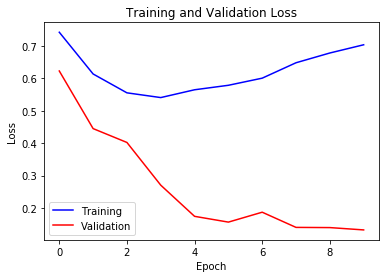

In [4]:
plot(training_loss, validation_loss)

Average Dice Score Accuracy:  0.8663208603858947


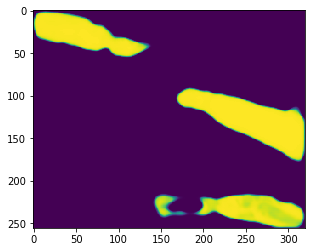

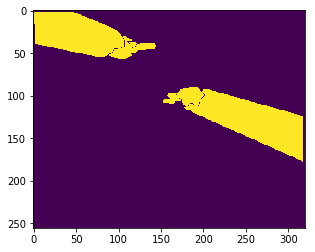

In [5]:
test_dataset=ImageDatasetAugmentation(input_dir = "./HW6_data/segmentation/test/")    
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                       batch_size=10)
def dice_coeff(y_hat, y):
    smooth = 1
    loss = 0
    classes = y_hat.shape[0]
    total = 0
    for i in range(classes):
        flatInp = y_hat[i].flatten()
        flatLabel = y[i].flatten()
        intersect = (flatInp * flatLabel).sum()
        total += ((2. * intersect + smooth) /
                    (flatInp.sum() + flatLabel.sum() + smooth))
    return total / classes

score_sum = 0
count = 0
with torch.no_grad():    
    for ind, data in enumerate(test_loader):
        model_aug.eval()
        x = autograd.Variable(data[0]).cuda()
        y = autograd.Variable(data[1]).long().cuda()
        y_hat = model_aug(x)
        plt.figure(100)
        plt.imshow(y_hat[0][3].cpu().detach())
        plt.figure(200)
        plt.imshow(y[0][3].cpu().detach())
        acc = dice_coeff(y_hat, y)
        score_sum += acc.item()
        count += 1
        
    print("Average Dice Score Accuracy: ", score_sum / count);

# 1 C

In [3]:
import random
######################## Hyperparameters #################################
# Batch size can be changed if it does not match your memory, please state your batch step_size
# in your report.
train_batch_size = 10
validation_batch_size=10
# Please use this learning rate for Prob1(a) and Prob1(b)
learning_rate = 0.01
# This num_epochs is designed for running to be long enough, you need to manually stop or design
# your early stopping method.
num_epochs = 10

# TODO: Design your own dataset
class ImageDatasetAugmentation(Dataset):
    def __init__(self, input_dir, transform=False):
        datalist = []
        labellist = []
        onehotlabellist = []
        for folders in os.listdir(input_dir):
            new_dir = os.path.join(input_dir, folders)
            if os.path.isdir(new_dir):
                impath = new_dir+ '/'+folders+'_input.jpg'
                labelpath = new_dir+ '/'+folders+'_mask.png'
                im = Image.open(impath)
                imLab = Image.open(labelpath)
                datalist.append(np.array(im))
                labellist.append(np.array(imLab))
        test = np.transpose(np.array(datalist), (0, 3, 1, 2))
        self.data = torch.from_numpy(np.transpose(np.array(datalist), (0, 3, 1, 2))).type('torch.FloatTensor')
        npLabel = np.array(labellist)
        labels = [0, 32, 64, 96, 128, 160, 192, 224]
        print("start process")
        for i in npLabel:
            imgs = []
            for j in labels:
                mask = self.mask(i, j)
                imgs.append(mask)
            onehotlabellist.append(np.array(imgs))
        print("finish process")
        self.label = torch.from_numpy(np.array(onehotlabellist)).type('torch.FloatTensor')
        self.transform = transform
        
    def mask(self, label, val):
        return label == val
        
    def __len__ (self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        data = self.data[idx]
        label = self.label[idx]
        # Vertical Flip
        if self.transform:
            if random.random() > 0.8:
                if random.random() > 0.7:
                    data = data.permute(1, 2, 0)
                    data = transforms.ToTensor()(TF.vflip(transforms.ToPILImage()(np.uint8(data))))
                    for i in range(label.shape[0]):
                        label[i] = transforms.ToTensor()(TF.vflip(transforms.ToPILImage()(np.uint8(label[i]))))
                # Horizontal Flip
                if random.random() > 0.7:
                    data = data.permute(1, 2, 0)
                    data = transforms.ToTensor()(TF.hflip(transforms.ToPILImage()(np.uint8(data))))
                    for i in range(label.shape[0]):
                        label[i] = transforms.ToTensor()(TF.hflip(transforms.ToPILImage()(np.uint8(label[i]))))

                # Change Brightness, Hue, Saturation
                if random.random() > 0.7:
                    data = data.permute(1, 2, 0)
                    data = transforms.ToTensor()(transforms.ColorJitter(brightness=random.uniform(0, 1), hue=random.uniform(0, 0.5), 
                                                                        saturation=random.uniform(0, 1))
                                                 (transforms.ToPILImage()(np.uint8(data))))  
        return data, label


def dice_coeff(y_hat, y):
    eps = 1
    loss = 0
    classes = y_hat.shape[0]
    total = 0
    for i in range(classes):
        flatInp = y_hat[i].flatten()
        flatLabel = y[i].flatten()
        intersect = (flatInp * flatLabel).sum()
        total += ((2. * intersect + eps) /
                    (flatInp.sum() + flatLabel.sum() + eps))
    return total / classes
    
# TODO: Implement DICE loss
class DICELoss(nn.Module):
    def forward(self, y_hat, y):
        dice = dice_coeff(y_hat, y)
        return 1 - dice
 
 

# TODO: Use your designed dataset for dataloading
train_dataset=ImageDatasetAugmentation(input_dir = "./HW6_data/segmentation/train/", transform=True)
validation_dataset=ImageDatasetAugmentation(input_dir =  "./HW6_data/segmentation/validation/")
model_aug = unet(useBN = True)
model_aug.cuda()
optimizer = torch.optim.Adam(model_aug.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                       batch_size=train_batch_size, 
                                       shuffle=True)
    
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, 
                                           batch_size=validation_batch_size, 
                                           shuffle=True)

training_loss = []
validation_loss = []
training_iter = iter(train_loader)
validation_iter = iter(validation_loader)
print("Start Training...")
for epoch in range(num_epochs):

    ########################### Training #####################################
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # TODO: Design your own training section
    model_aug.train()
    train_tot = 0
    count = 0
    for ind, training_data in enumerate(train_loader):
        x = autograd.Variable(training_data[0]).cuda()
        y = autograd.Variable(training_data[1]).long().cuda()

        optimizer.zero_grad()
        y_hat = model_aug(x)
        train_loss = DICELoss()(y_hat, y)
        train_loss.backward()
        optimizer.step()
        count += 1
        train_tot += train_loss.data.item()
    print(train_tot / count)
    training_loss.append(train_tot / count)
    

    ########################### Validation #####################################
    # TODO: Design your own validation section
    val_tot = 0
    count = 0
    model_aug.eval()
    print("\nStart Validation...")
    with torch.no_grad():
        for ind, valid_data in enumerate(validation_loader):
            x = autograd.Variable(valid_data[0]).cuda()
            y = autograd.Variable(valid_data[1]).long().cuda()
            y_hat = model_aug(x)
            val_loss = DICELoss()(y_hat, y)
            val_tot += val_loss.data.item()
            count += 1
        print(val_tot / count)
        validation_loss.append(val_tot / count)

start process
finish process
start process
finish process
Start Training...

EPOCH 1 of 10

0.43384037017822263

Start Validation...
0.5010549664497376

EPOCH 2 of 10

0.30776219566663104

Start Validation...
0.19241384267807007

EPOCH 3 of 10

0.3315000176429749

Start Validation...
0.14599050283432008

EPOCH 4 of 10

0.38163668115933735

Start Validation...
0.13427015542984008

EPOCH 5 of 10

0.44048418005307516

Start Validation...
0.1332034468650818

EPOCH 6 of 10

0.4946971595287323

Start Validation...
0.17224158048629762

EPOCH 7 of 10

0.5407283465067546

Start Validation...
0.11106535196304321

EPOCH 8 of 10

0.5767895877361298

Start Validation...
0.11121561527252197

EPOCH 9 of 10

0.6194296956062317

Start Validation...
0.11746768951416016

EPOCH 10 of 10

0.6462860683600108

Start Validation...
0.1213253378868103


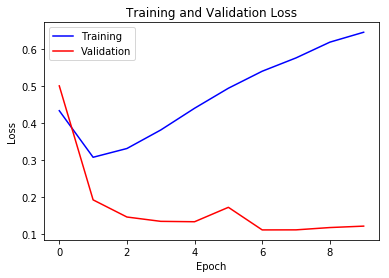

In [4]:
plot(training_loss, validation_loss)

start process
finish process
Average Dice Score Accuracy:  0.8792661309242249


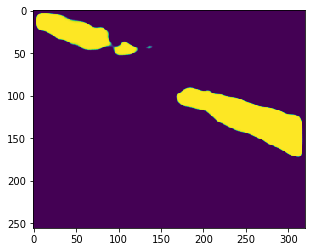

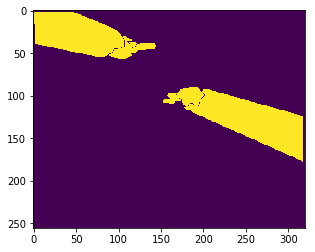

In [5]:
test_dataset=ImageDatasetAugmentation(input_dir = "./HW6_data/segmentation/test/")    
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                       batch_size=10)
def dice_coeff(y_hat, y):
    smooth = 1
    loss = 0
    classes = y_hat.shape[0]
    total = 0
    for i in range(classes):
        flatInp = y_hat[i].flatten()
        flatLabel = y[i].flatten()
        intersect = (flatInp * flatLabel).sum()
        total += ((2. * intersect + smooth) /
                    (flatInp.sum() + flatLabel.sum() + smooth))
    return total / classes

score_sum = 0
count = 0
with torch.no_grad():    
    for ind, data in enumerate(test_loader):
        model_aug.eval()
        x = autograd.Variable(data[0]).cuda()
        y = autograd.Variable(data[1]).long().cuda()
        y_hat = model_aug(x)
        plt.figure(100)
        plt.imshow(y_hat[0][3].cpu().detach())
        plt.figure(200)
        plt.imshow(y[0][3].cpu().detach())
        acc = dice_coeff(y_hat, y)
        score_sum += acc.item()
        count += 1
        
    print("Average Dice Score Accuracy: ", score_sum / count);